# Trabalho Prático 1
### Matéria: Introdução a Computação Visual
### Alunos: Luís Gustavo Costa da Silva, Matheus Marchesotti Dutra Ferraz
### Matrículas:

 #### *Descrição*
 Abkaskdjkasjdlajflasdj

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from math import log10

In [2]:
def visualize(image_matrix, title):
    plt.title(title)
    image_plot = plt.imshow(image_matrix)
    plt.colorbar()
    return

In [47]:
def psnr(matrix_i, matrix_k):
    m, n = matrix_i.shape
    
    mse = 0
    for i in range(m-1):
        for j in range(n-1):
            mse = mse + (matrix_i[i][j] - matrix_k[i][j])**2
            
    mse = mse/(m*n)
    max_number = max(max(matrix_i))
    psne = 10*log10(max_number**2 / mse)
    
    return psne

In [4]:
def compress_rate(original_image, compressed_image):
    pixels_i, pixels_j = original_image.shape
    compressed_pixels_i, compressed_pixels_j = compressed_image.shape
    
    compress_rate =  (compressed_pixels_i*compressed_pixels_j) / (pixels_i*pixels_j)
    
    return compress_rate

In [5]:
def subtract_matrix(image_matrix):
    subtract_128 = lambda i: i - 128
    vectorized_subtract_128 = np.vectorize(subtract_128)
    subtracted_image_matrix = vectorized_subtract_128(image_matrix)

    return subtracted_image_matrix

In [6]:
def add_matrix(image_matrix):
    add_128 = lambda i: i + 128
    vectorized_add_128 = np.vectorize(add_128)
    added_image_matrix = vectorized_add_128(image_matrix)

    return added_image_matrix

In [7]:
def add_padding(image_matrix):
    rows, columns = image_matrix.shape

    if(rows%8!=0):
        rows -= rows%8-8
    if(columns%8!=0):
        columns -= columns%8-8
        
    padded_image = np.zeros((rows,columns))
    padded_image[:image_matrix.shape[0],:image_matrix.shape[1]] = image_matrix
    
    return padded_image

In [8]:
def remove_padding(image_matrix):
    rows, columns = original_image.shape
    
    unpadded_image = image_matrix[:rows, :columns]
    
    return unpadded_image

In [9]:
def compress(image_matrix, quantization_table):
    padded_matrix = add_padding(image_matrix)
    codified_matrix = np.zeros(padded_matrix.shape)

    rows, columns = padded_matrix.shape
    
    for r in range(0, rows, 8):
        for c in range(0, columns, 8):
            submatrix = padded_matrix[r:r+8, c:c+8]

            subtracted = subtract_matrix(submatrix)

            dct = cv2.dct(subtracted)

            quantized = np.divide(dct, quantization_table)
            quantized = np.around(quantized, decimals=0)

            codified_matrix[r:r+8, c:c+8] = quantized
            
    return codified_matrix

In [ ]:
class HuffmanTree():
    
    def __init__(self, root=None, left=None, right=None):
        self.root = root
        self.left = left
        self.right = right
        
    def getRight(self):
        return self.right
    
    def getLeft(self):
        return self.left
    
    def getRoot(self):
        return self.root

In [ ]:
def computeHuffman(HuffmanTree, binaryString=''):
        
        if type(HuffmanTree) == str:
            return {HuffmanTree: binaryString}
        
        leftChild, rightChild = HuffmanTree.getLeft(), HuffmanTree.getRight()
        catalog = {}
        catalog.update(computeHuffman(leftChild, binaryString + '0'))
        catalog.update(computeHuffman(rightChild, binaryString + '1'))
        
        return catalog

In [ ]:
def calculateFrequency(matrix):
    
    codeArray = matrix.reshape(-1)
    frequency = {}
    
    for item in codeArray:
        item = str(item)
        if item in frequency:
            frequency[item] += 1
        else:
            frequency[item] = 1
            
    for key in frequency:
        frequency[key] = float(frequency[key])/len(codeArray)
        
    frequency_sorted = sorted(frequency.items(), key=lambda pairs:pairs[1], reverse=True)
    return frequency_sorted

In [ ]:
def codificate(probabilityList):
    
    while len(probabilityList) > 1:
        
        (symbol_1, probability_1) = probabilityList[-1]
        (symbol_2, probability_2) = probabilityList[-2]
        
        probabilityList = probabilityList[:-2]
        
        HuffmanRoot = HuffmanTree(None, symbol_1, symbol_2)
        probabilityList.append((HuffmanRoot, probability_1+probability_2))
        
        probabilityList = sorted(probabilityList, key=lambda pairs:pairs[1], reverse=True)
        
    huffmanCode = computeHuffman(probabilityList[0][0])
    
    return huffmanCode

In [17]:
def decompress(codified_matrix, quantization_table):
    
    decodified_image = np.zeros(codified_matrix.shape)

    rows, columns = decodified_image.shape
    for r in range(0, rows, 8):
        for c in range(0, columns, 8):
            submatrix = codified_matrix[r:r+8, c:c+8]

            dequantized = np.multiply(submatrix, quantization_table)

            inverse_dct = cv2.idct(dequantized)

            decodified = add_matrix(inverse_dct)
            decodified = np.around(decodified, decimals=0)

            decodified_image[r:r+8, c:c+8] = decodified

    decodified_image = remove_padding(decodified_image)
    
    if(decodified_image.min()<0):
        decodified_image -= -decodified_image.min()
    if(decodified_image.max()>255):
        decodified_image *= 255.0/decodified_image.max()
    
    return decodified_image

In [11]:
quantization_table_1 = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]]
)
quantization_table_2 = np.array(
    [
        [17, 18, 24, 47, 99, 99, 99, 99],
        [18, 21, 26, 66, 99, 99, 99, 99],
        [24, 26, 56, 99, 99, 99, 99, 99],
        [47, 66, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99],
        [99, 99, 99, 99, 99, 99, 99, 99]
    ]
)

In [35]:
# load
original_image = cv2.imread('woman-relaxed-work.jpg',0)
original_image

array([[217, 217, 216, ..., 172, 171, 170],
       [218, 217, 216, ..., 176, 175, 175],
       [218, 218, 217, ..., 174, 174, 175],
       ...,
       [171, 173, 173, ..., 192, 193, 192],
       [174, 172, 173, ..., 191, 192, 192],
       [175, 169, 172, ..., 189, 191, 191]], dtype=uint8)

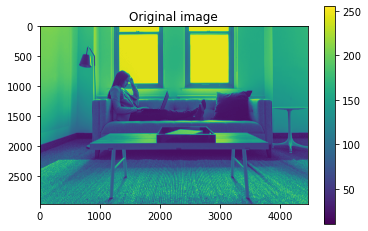

In [36]:
# visualize
visualize(original_image, "Original image")

In [37]:
image_matrix = np.array(original_image)
image_matrix

array([[217, 217, 216, ..., 172, 171, 170],
       [218, 217, 216, ..., 176, 175, 175],
       [218, 218, 217, ..., 174, 174, 175],
       ...,
       [171, 173, 173, ..., 192, 193, 192],
       [174, 172, 173, ..., 191, 192, 192],
       [175, 169, 172, ..., 189, 191, 191]], dtype=uint8)

In [38]:
# compress
codified_image = compress(image_matrix, quantization_table_1)

In [39]:
# save

In [40]:
# decompress
decodified_image = decompress(codified_image, quantization_table_1)

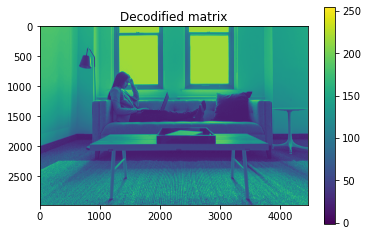

In [41]:
# visualize
visualize(decodified_image, 'Decodified matrix')

Text(0.5, 1.0, 'Decodified image')

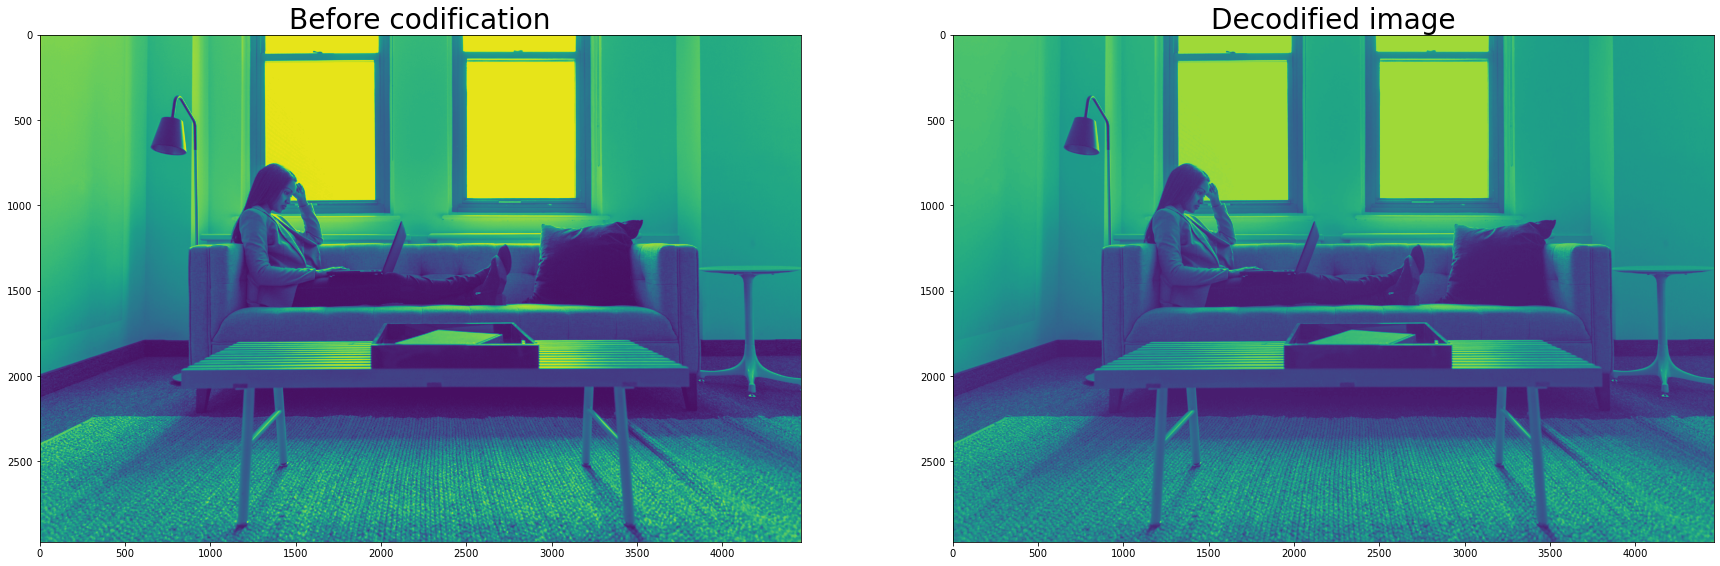

In [42]:
# final comparisson

figure = plt.figure(figsize=(30,30))

ax = figure.add_subplot(1, 2, 1)
image_plot = plt.imshow(original_image)
ax.set_title("Before codification", fontsize=28)

ax = figure.add_subplot(1, 2, 2)
image_plot = plt.imshow(decodified_image)
ax.set_title("Decodified image", fontsize=28)

In [50]:
# psnr and compress rate
#psnr_result = psnr(original_image, decodified_image)
#print(psnr_result)